In [1]:
# if you haven't pulled the "subtract_psf" directory from GitHub, skip this cell
from klip_retrieve import KlipRetrieve

In [2]:
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import time

# Load tables

### Original instructions

<blockquote>

*Here is the full resolution planet flux and wavelength. The flux units are in ~~ergs/s/cm^2/cm~~ **ergs/s/cm^2/cm/sr** and the wavelength is in **micron**, so you should have way more than you need (it goes out to 900 microns). (file: 2048_377_6micron.txt). (ignore the 6micron title part, you have the full res, full wavelength file)*

*Also attached is the star, this is high resolution as well. The flux is in the same units (**ergs/s/cm^2/cm/sr**), the wavelengths are in **Angstroms** for the star and it goes out to about 5.5 microns or 55000 Angstroms. (kappa_star_model.txt) This should be enough for NIRSpec.*
</blockquote>

### Flux/radiance refresher

Different types of flux are often confusingly named, so I did a small review.

**Spectral radiance/spectral brightness/specific intensity** is the power *emitted* by a surface per unit projcted area *and* per unit solid angle. This means:
- Planck's Law blackbody specific intensity, per unit wavelength, is: $W\, /\, sr\, /\, m^3$.
- Planck's Law blackbody specific intensity, per unit frequency, is: $W\, /\, sr\, /\, m^2\, /\, Hz$.

*(`astropy`'s deprecated [`blackbody_lambda`](https://docs.astropy.org/en/stable/api/astropy.modeling.blackbody.blackbody_lambda.html) and [`blackbody_nu`](https://docs.astropy.org/en/stable/api/astropy.modeling.blackbody.blackbody_nu.html) methods, respectively, return values in these units. The new [`BlackBody`](https://docs.astropy.org/en/stable/api/astropy.modeling.physical_models.BlackBody.html) class can return either unit.)*
<br>
*[ to convert between different forms of blackbody specific intensity:
$\frac{B(\lambda, T)}{B(\nu, T)} = c / \lambda^2 = \nu^2 / c$ (given that $\lambda = c / \nu$) ]*

**Spectral irradiance/flux density** is the power *received* by surface per unit area.
- flux density units per unit wavelength are $W\, /\, m^3$.
- flux density units per unit frequency are $W\, /\, m^2\, /\, Hz$.

*(`astropy`'s deprecated [`BlackBody1D`](https://docs.astropy.org/en/stable/api/astropy.modeling.blackbody.BlackBody1D.html) class returns flux densities in these units.)*
<br>
*(Janskys, which are used later on in the notebook, are a unit of flux density.)*

We use flux densities to measure contrast. Since the Kappa And files contain specific intensities, we need to get rid of the "per unit solid angle" by multiplying both intensity columns by the projected area of their respective object on the sky.

[Additional](https://en.wikipedia.org/wiki/Radiant_intensity#SI_radiometry_units) [links](www.cv.nrao.edu/course/astr534/Brightness.html) [of](https://en.wikipedia.org/wiki/Planck's_law#The_law) [interest](https://en.wikipedia.org/wiki/Planck's_law#Correspondence_between_spectral_variable_forms).

In [3]:
flux_units = u.erg / u.s / u.cm**3

In [4]:
# save Kappa And system information
rad_kapA = (2.31 * 696.34 * 1e6 * u.m).to(u.solRad)
rad_kapb = (1.2 * 69.911 * 1e6 * u.m).to(u.jupiterRad)
dist_kap = (1.5922e18 * u.m).to(u.pc)
sep_au = 55 * u.AU
rad_kapA, rad_kapb, dist_kap, sep_au

(<Quantity 2.31212505 solRad>,
 <Quantity 1.17346277 jupiterRad>,
 <Quantity 51.59968785 pc>,
 <Quantity 55. AU>)

In [5]:
# load Kappa And A
#new_star = Table.read('/Users/jotor/Downloads/kappa_star_model.txt')
new_star = Table.read('/user/jotor/real_spectra/kappa_star_model.txt', format='ascii')

In [6]:
# order and name columns for proper reading in KlipRetrieve
new_star.rename_column('col2', 'wavelength')
new_star.rename_column('col1', 'flux')
new_star = new_star[new_star.colnames[::-1]]

In [7]:
# assign units to columns following original instructions
new_star['wavelength'].unit = u.angstrom
new_star['wavelength'] = new_star['wavelength'].to(u.micron) # change to match other table
new_star['flux'].unit = u.erg / u.s / u.cm**2 / u.cm / u.sr

In [8]:
# scale and multiply out steradians to get a true flux density
new_star['flux'] = (new_star['flux'] * np.pi * (rad_kapA / dist_kap * u.rad)**2).to(flux_units)

In [9]:
# load Kappa And b
#new_comp = Table.read('/Users/jotor/Downloads/2048_377_6micron.txt', format='ascii')
new_comp = Table.read('/user/jotor/real_spectra/2048_377_6micron.txt', format='ascii')

In [10]:
# order and name columns for proper reading in KlipRetrieve
new_comp.rename_column('col2', 'wavelength')
new_comp.rename_column('col1', 'flux')
new_comp = new_comp[new_comp.colnames[::-1]]

In [11]:
# assign units to columns following original instructions
new_comp['wavelength'].unit = u.micron
new_comp['flux'].unit = u.erg / u.s / u.cm**2 / u.cm / u.sr

In [12]:
# scale and multiply out steradians to get a true flux density
new_comp['flux'] = (new_comp['flux'] * np.pi * (rad_kapb / dist_kap * u.rad)**2).to(flux_units)

In [13]:
# choose a wavelength range to plot
#wv_lo = 1 * u.micron
wv_lo = 2.87 * u.micron # from nirspec
wv_hi = 5.27 * u.micron # from nirspec

# limit tables to entries with wavelengths between these two values
star_entries = np.argwhere((new_star['wavelength'].quantity >= wv_lo)
                           & (new_star['wavelength'].quantity <= wv_hi)).flatten()

comp_entries = np.argwhere((new_comp['wavelength'].quantity >= wv_lo)
                           & (new_comp['wavelength'].quantity <= wv_hi)).flatten()

In [14]:
# get astropy quantity arrays for wavelengths and flux densities to be plotted
wv_star_plot = new_star['wavelength'][star_entries].quantity
wv_comp_plot = new_comp['wavelength'][comp_entries].quantity

scaled_star_flux = new_star['flux'][star_entries].quantity
scaled_comp_flux = new_comp['flux'][comp_entries].quantity

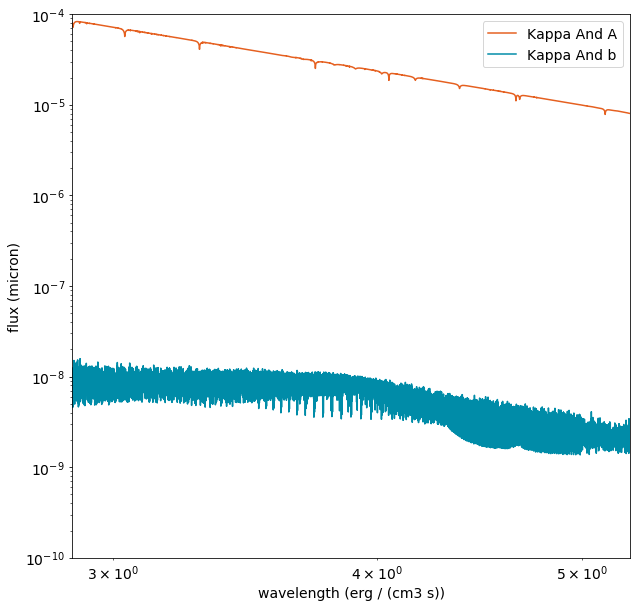

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
                       
plt.loglog(wv_star_plot, scaled_star_flux, label='Kappa And A', c='#e56020')
plt.loglog(wv_comp_plot, scaled_comp_flux, label='Kappa And b', c='#008ca8')
plt.legend(fontsize=14)

# get orders of magnitude of lowest comp/highest star flux density values
# and use them to set y limits
plt.ylim(10**(np.floor((np.log10(scaled_comp_flux.min().value))) - 1),
         10**(np.floor((np.log10(scaled_star_flux.max().value))) + 1))
plt.xlim(wv_lo.value, wv_hi.value)

plt.xlabel(f"wavelength ({scaled_star_flux.unit})", fontsize=14)
plt.ylabel(f"flux ({wv_comp_plot.unit})", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#plt.savefig('kappa_and_spectra_new.png', dpi=300)

*Helpful rule of thumb: `magnitude difference = -2.5 * contrast order of magnitude`*.

For example, two objects with a contrast of $10^{-4}$ are about `-2.5 * 4 =` 10 magnitudes apart from each other.
<br>
Or, two objects that are 5 magnitudes apart, since `5 / -2.5 = 2`, have a contrast of about $10^{-2}$.

# Inject a simulated data cube

In this section, I use code from my class that can use the spectra we read in earlier (`new_star` and `new_comp`) to inject a companion into a data cube of simulated NirSpec target observations. It then attempts to subtract the star's flux from the image through KLIP, using another data cube of simulated reference star observations to calculate the PCA basis.

(Note that for now, the star is scaled to have the same brightness in all slices, so the companion's brightness is influenced by changes in both its spectrum *and* the star's spectrum.)

Finally, I provide code to save a PDF with subtraction results plots for all slices of a data cube.

*(if you've imported `KlipRetrieve` and are curious about one of the class methods, put your cursor on it and press `Shift`+`Tab` a couple of times to view the docstrings.)*

In [16]:
# get kappa and b's separation in arcseconds
print(f"distance is {dist_kap:.2f}; separation in physical units is {sep_au:.2f}.")
sep_arc = np.arctan(sep_au / dist_kap).to(u.arcsec)
sep_arc

distance is 51.60 pc; separation in physical units is 55.00 AU.


<Quantity 1.06589792 arcsec>

In [17]:
# upload simulated, lower resolution (30 slices) data cubes
ex3 = KlipRetrieve('/user/jotor/gen_images/30_slice_4_os8/')

commence removal of dither shifts
(30, 30, 30) data cube shape at beginning
(30, 34, 34) data cube shape at end

[(20, 16), (21, 16), (20, 16), (21, 16), (20, 16), (21, 15), (21, 16), (21, 16), (20, 16), (20, 16)] 
 [(15, 17), (15, 17), (14, 17), (15, 17), (14, 17), (15, 16), (15, 17), (15, 17), (14, 17), (15, 17)]
6 2
(30, 34, 34) data cube shape at beginning
(30, 38, 46) data cube shape at end

(30, 25, 21) data cube shape after removing padding

********
non-padded image shape: (25, 21)
********

********
injecting companion with (location-specific) 5-sigma intensity.
********
max_safes 10 6
[-6 -5 -4 -3 -2  2  3  4  5  6]
[-10  -9  -8  -7  -6  -5  -4  -3  -2   2   3   4   5   6   7   8   9  10]
12.0 -3 -4


In [18]:
# inject a companion, scaling its flux density according to tables' spectral data
sfs, cfs = ex3.scale_from_spectra(star_spectrum=new_star, comp_spectrum=new_comp,
                                  separation=sep_arc.value)

# convert returned flux density arrays from Janskys to units from first section
sfs = sfs.to(flux_units, u.spectral_density(ex3.wvlnths * u.m))
cfs = cfs.to(flux_units, u.spectral_density(ex3.wvlnths * u.m))


********
injecting companion with spectrally defined intensity.
********
max_safes 10 6
[-6 -5 -4 -3 -2  2  3  4  5  6]
[-10  -9  -8  -7  -6  -5  -4  -3  -2   2   3   4   5   6   7   8   9  10]
3 iterations
12.0 -10 -4

********
new, injected target images in `self.injected_cubes`.
********
['1e-04', '1e-04', '1e-04', '1e-04', '2e-04', '2e-04', '2e-04', '2e-04', '2e-04', '2e-04', '3e-04', '3e-04', '3e-04', '3e-04', '3e-04', '3e-04', '3e-04', '3e-04', '3e-04', '3e-04', '2e-04', '2e-04', '2e-04', '3e-04', '3e-04', '3e-04', '3e-04', '3e-04', '3e-04', '3e-04']



********
total intensity pre-subtract:  9.2309e-01
total intensity post-subtract: 1.2849e-02
********


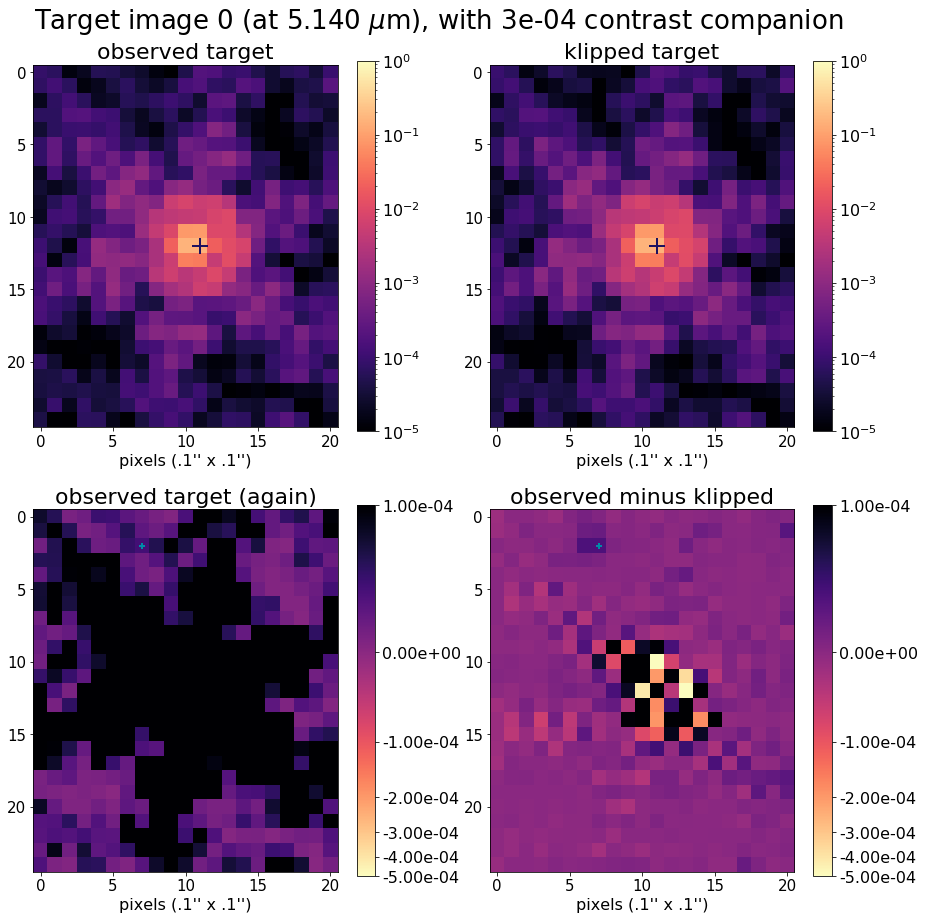

(0.9230879469259947, 0.012848607220582916)

In [19]:
# examine pre and post-subtraction versions of one slice of one injected image
ex3.plot_subtraction(companion=True, target_image=0, wv_slice=-1)

In [ ]:
# inject a random companion instead -- included for reference's sake
#ex3.inject_companion(comp_scale=2, separation=.4)

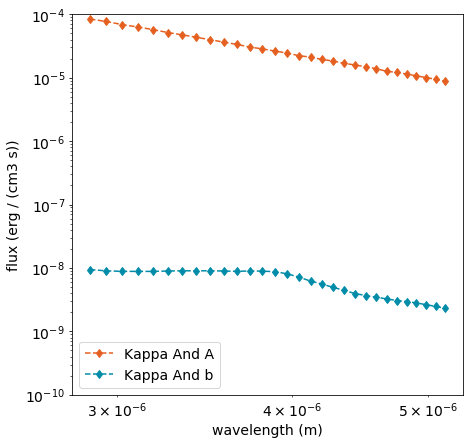

In [20]:
# plot binned down versions of spectra used for injection above
fig, ax = plt.subplots(figsize=(7,7))

plt.loglog(ex3.wvlnths, sfs, '--d', label='Kappa And A', c='#e56020', markersize=6)
plt.loglog(ex3.wvlnths, cfs, '--d', label='Kappa And b', c='#008ca8', markersize=6)
plt.legend(fontsize=14)

plt.ylim(10**(np.floor((np.log10(cfs.min().value))) - 1),
         10**(np.floor((np.log10(sfs.max().value))) + 1))
plt.xlabel(f"wavelength (m)", fontsize=14)
plt.ylabel(f"flux ({flux_units})", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

# Save the results in a PDF

In [21]:
from matplotlib.backends.backend_pdf import PdfPages

In [23]:
def automate_pdf(file_start, companion, num_slices):
    '''
    Create a pdf from plot_subtraction() results. `file_start` is a string version
    of the intended file name (without the '.pdf'), `companion` is a boolean controlling
    whether the images will contain a companion (you probably want True), and `num_slices`
    is the number of slices for which to generate plots. For all slices, just use
    `len(obj.wvlnths)`, where `obj` is your KlipRetrieve instance.
    
    In my tests, it takes about a second to generate a plot, so this will take a long
    time with the full resolution data cube. The one in this example is just 30 slices,
    so it shouldn't take too long.
    '''
    with PdfPages(file_start + '.pdf') as pdf:
        start = time.time()
        for i in range(num_slices):
            fig = ex3.plot_subtraction(companion=companion, wv_slice=i, return_plot=True)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
        print(time.time() - start, 's')

In [26]:
automate_pdf('kappa_cube', True, len(ex3.wvlnths))


********
total intensity pre-subtract:  9.4894e-01
total intensity post-subtract: 3.0657e-02
********

********
total intensity pre-subtract:  9.4786e-01
total intensity post-subtract: 2.9771e-02
********

********
total intensity pre-subtract:  9.4692e-01
total intensity post-subtract: 2.9180e-02
********

********
total intensity pre-subtract:  9.4592e-01
total intensity post-subtract: 2.8227e-02
********

********
total intensity pre-subtract:  9.4482e-01
total intensity post-subtract: 2.6298e-02
********

********
total intensity pre-subtract:  9.4366e-01
total intensity post-subtract: 2.4962e-02
********

********
total intensity pre-subtract:  9.4288e-01
total intensity post-subtract: 2.3009e-02
********

********
total intensity pre-subtract:  9.4214e-01
total intensity post-subtract: 2.1437e-02
********

********
total intensity pre-subtract:  9.4112e-01
total intensity post-subtract: 1.9753e-02
********

********
total intensity pre-subtract:  9.3992e-01
total intensity post-

Open the resulting PDF and flip through from page-to-page for an effect similar to opening a FITS file in ds9.